# this is an control experiment to the graph approach
- Since the original information is text, normal ML models cannot be employed easily (i.e., they accept only table-type databases)
- Apart from graph approach, conventional language learning models can be used, anyway
- Here, a famous model, LSTM, is used to input the data

In [1]:
import joblib
import re

# converting to text to problems for LSTM
1. extract answers (conductivity) from the text
- replace conductivity part with "__unknown__"
- convert text to vectors (in a very conventional way)

In [2]:
#load txt
txtList=joblib.load("praparingGraphs/textList.bin")
txtList[0]

'a mixture (-0.95859 weight percent of C0001 ("PH_thousand") and 1.14449 weight percent of C0002) was spincoated,which was kept for -0.01331 minutes at 0.10497 Celsius,to which a mixture (-0.985 weight percent of C0004 and 1.17083 weight percent of C0002) was dropped,which was kept for -0.35009 minutes at 0.59875 Celsius,which was rinsed by C0002,which was kept for -0.35009 minutes at 0.59875 Celsius,which gave an electricconductivity (0.10507 Scm)'

In [3]:
#prepare target list
targets=[re.findall('electricconductivity(.+?)Scm',txt)[0] for txt in txtList]
targets=[float(t.replace("(","").replace(" ","")) for t in targets]
targets[:4]

[0.10507, 0.36267, 0.41802, 0.48658]

In [4]:
#prepare problems
problems=[re.sub('electricconductivity(.+?)Scm','electric conductivity of __unknown__ S/cm',txt) for txt in txtList]
problems[:2]

['a mixture (-0.95859 weight percent of C0001 ("PH_thousand") and 1.14449 weight percent of C0002) was spincoated,which was kept for -0.01331 minutes at 0.10497 Celsius,to which a mixture (-0.985 weight percent of C0004 and 1.17083 weight percent of C0002) was dropped,which was kept for -0.35009 minutes at 0.59875 Celsius,which was rinsed by C0002,which was kept for -0.35009 minutes at 0.59875 Celsius,which gave an electric conductivity of __unknown__ S/cm)',
 'a mixture (-0.95859 weight percent of C0001 ("PH_thousand") and 1.14449 weight percent of C0002) was spincoated,which was kept for -0.01331 minutes at 0.10497 Celsius,to which a mixture (-0.66623 weight percent of C0004 and 0.85148 weight percent of C0002) was dropped,which was kept for -0.35009 minutes at 0.59875 Celsius,which was rinsed by C0002,which was kept for -0.35009 minutes at 0.59875 Celsius,which gave an electric conductivity of __unknown__ S/cm)']

In [5]:
#split dataset
from sklearn.model_selection import train_test_split
xTr, xTe, yTr, yTe = train_test_split(problems, targets, test_size=0.3, random_state=0)

In [6]:
#simply convert words to vectors by keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxLen = max([txt.count(" ") for txt in problems])  #154

tokenizer = Tokenizer()
tokenizer.fit_on_texts(problems)
xVTr = tokenizer.texts_to_sequences(xTr)
xVTe = tokenizer.texts_to_sequences(xTe)

for text, vector in zip(xTr[:3], xVTr[0:3]):
    print(text)
    print(vector)

xTokenTr = pad_sequences(xVTr, maxlen=maxLen)
xTokenTe = pad_sequences(xVTe, maxlen=maxLen)

Using TensorFlow backend.


a mixture (-0.95859 weight percent of C0001 ("PH_thousand") and 1.14449 weight percent of C0002) was spincoated,which was kept for -0.01331 minutes at 0.10497 Celsius,to which a mixture (-0.37034 molar concentration of C0006 in C0013) was dropped,which was kept for -0.35009 minutes at 2.08008 Celsius,which was rinsed by C0002,which was kept for -0.35009 minutes at 0.59875 Celsius,which gave an electric conductivity of __unknown__ S/cm)
[13, 14, 1, 27, 5, 6, 4, 19, 28, 29, 16, 15, 32, 5, 6, 4, 12, 2, 18, 3, 2, 9, 10, 1, 39, 11, 7, 1, 17, 8, 30, 3, 13, 14, 1, 48, 37, 38, 4, 49, 41, 59, 2, 31, 3, 2, 9, 10, 1, 35, 11, 7, 42, 107, 8, 3, 2, 33, 34, 12, 3, 2, 9, 10, 1, 35, 11, 7, 1, 40, 8, 3, 20, 21, 22, 23, 4, 24, 25, 26]
a mixture (-0.95859 weight percent of C0001 ("PH_thousand"), 1.14449 weight percent of C0002, and -0.38595 molar concentration of C0050) was spincoated,which was kept for -0.1817 minutes at 0.10497 Celsius,which gave an electric conductivity of __unknown__ S/cm)
[13, 14, 1,

In [7]:
#simply train with a LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.callbacks import EarlyStopping 

vocabularySize = len(tokenizer.word_index) + 1 
model = Sequential()
model.add(Embedding(input_dim=vocabularySize, output_dim=32))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam')

model.summary()

early_stopping = EarlyStopping(patience=10, verbose=1) 
history = model.fit(
    xTokenTr, yTr, batch_size=32, epochs=100,
    validation_data=(xTokenTe, yTe),
    callbacks=[early_stopping]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          12512     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,665
Trainable params: 15,665
Non-trainable params: 0
_________________________________________________________________


/home/kh/anaconda3/envs/chem/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 238 samples, validate on 102 samples
Epoch 1/100
238/238 [==============================] - 1s 5ms/step - loss: 0.8607 - val_loss: 1.3349
Epoch 2/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8558 - val_loss: 1.3430
Epoch 3/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8537 - val_loss: 1.3543
Epoch 4/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8522 - val_loss: 1.3614
Epoch 5/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8501 - val_loss: 1.3563
Epoch 6/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8452 - val_loss: 1.3402
Epoch 7/100
238/238 [==============================] - 1s 3ms/step - loss: 0.8280 - val_loss: 1.2999
Epoch 8/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7648 - val_loss: 1.2382
Epoch 9/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7025 - val_loss: 1.0905
Epoch 10/100
238/238 [=======================

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

scaler=joblib.load("praparingGraphs/scalingDictForPEDOTPSS.bin")

In [9]:
def plot(x,y):
    pred=model.predict(x)
    y=scaler["Scm"].inverse_transform(y)
    pred=scaler["Scm"].inverse_transform(pred)

    plt.figure(figsize=(5,5))
    plt.axes().set_aspect('equal', 'datalim')
    plt.plot(y,pred,"o")
    print("R2: ",r2_score(y,pred))
    print("MAE: ",mean_absolute_error(y,pred))
    
    return y,pred

# Let's check results!
- Actually, the prediction accuracy is not so bad for this case
- However, this approach has many intrinsic problems like below:
    1. there is no obvious way for multitask training with other format, such as table-type, databases
    - Compound information was just treated as a simple text (e.g., C_0001)
        - this is weak against spelling variants
            - even "water" has many expressions, like H2O, dihydrogen monoxide, DHMO, ... 
            - therefore, an extremely large dataset will be needed to cope with this issue (maybe impossible...)
        - newly synthesized (very few data  available!) compounds cannot be converted to vectors appropriately
        - ...
    - Therefore, we employed a graph approach!

R2:  0.93994709881063
MAE:  0.2308949144338715


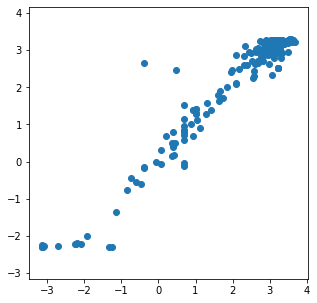

In [10]:
TrY,TrPred=plot(xTokenTr,yTr)

R2:  0.6632674873211077
MAE:  0.7038131007953385


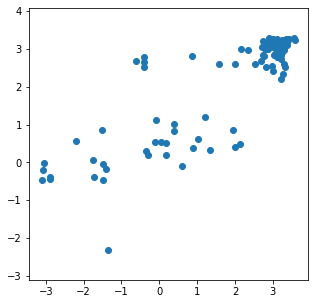

In [11]:
Te,TePred=plot(xTokenTe,yTe)

In [13]:
#import pandas as pd
#df=pd.DataFrame([TrY,TrPred,TeY,TePred])
#df.to_csv("res.csv")